In [1]:
import torch
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset


cudnn.benchmark = True
plt.ion()  # interactive mode

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=4GGSN2I65UXNQFB4FDGR
env: CLEARML_API_SECRET_KEY=Vcpn1kPYzygxkl4oTJ8ctsFLT7ctTMSmxV6Wuu6eh5yBADaQLT
Using cuda device


Load the Original Dataset

In [2]:
dataset = load_dataset("fusing/wikiart_captions")
dataset

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/81444 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/70 [00:00<?, ?it/s]

Example of caption content

In [3]:
dataset["train"]["text"][0]

['a landscape in the style of Vincent Van Gogh',
 'a landscape in the style of realism',
 'a realism painting by Vincent Van Gogh',
 'a landscape by Vincent Van Gogh']

Function to add an index for every sample in order to be certain of the corrispondence between newly generated captions and the images

In [4]:
counter_index = 0
def add_index(example):
    global counter_index
    example["index"] = counter_index
    counter_index += 1
    return example

Mapping function on the dataset

In [ ]:
dataset = dataset.map(add_index)
dataset

Re-Captioning Model (Moondream2 Multimodal Model)

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image

model_id = "vikhyatk/moondream2"
revision = "2024-05-20"
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, revision=revision
)
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)

/home/ater/miniforge3/envs/torch2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ater/miniforge3/envs/torch2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Function for recaptioning of a sample with prompt

In [9]:
def generate_captions_multimodal(image, model, tokenizer):
    enc_image = model.encode_image(image)
    return model.answer_question(enc_image, "Generate a short, simple and only visually descriptive caption for this image.", tokenizer)

Generate All the captions with corresponding index

In [11]:
new_captions = {}

for i in tqdm(dataset["train"], desc="Generating New Captions"):
    caption = generate_captions_multimodal(i["image"], model, tokenizer)
    new_captions[i["index"]] = caption

Generating New Captions: 100%|██████████| 81444/81444 [16:37:03<00:00,  1.36it/s]   


Save and Visualize all the new captions

In [14]:
new_capt_df = pd.DataFrame.from_dict(new_captions, orient="index", columns=["Caption"])
new_capt_df.to_csv("NewCaptionsIndexed.csv")
new_capt_df

Mapping function to substitute all the old captions with the new captions

In [17]:
def useNewCaptions(example):
    example["text"] = [new_capt_df.iloc[example["index"]]["Caption"]]
    return example

In [ ]:
dataset["train"] = dataset["train"].map(useNewCaptions, num_proc=4)

New Captions Visualization

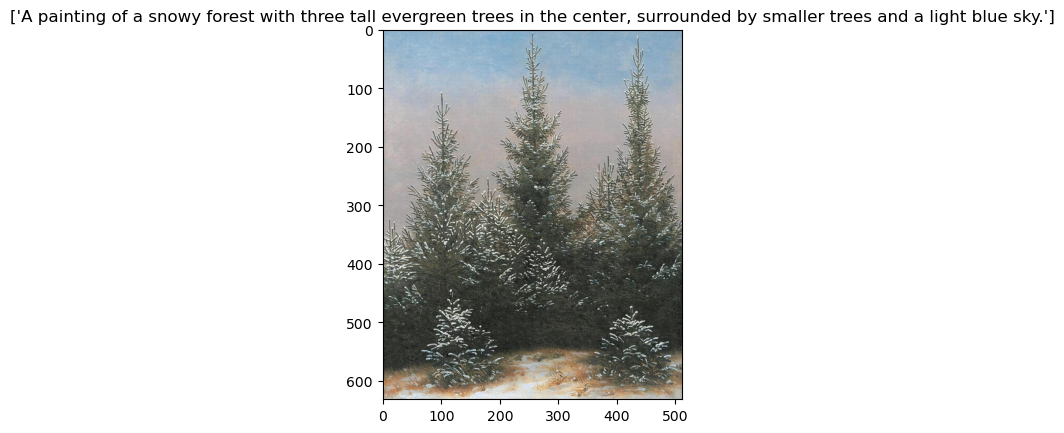

In [24]:
import random

#random int between 0 and 81444
index = random.randint(0, 81444)

# index = 7854
image = dataset["train"][index]["image"]
label = dataset["train"][index]["text"]
plt.imshow(np.array(image))
plt.title(label)
plt.show()

Filtering for erroneus captioning

In [ ]:
#Check for the max_length of all captions in the dataset and isolate all the captions longer than 200

max_length = 0
max_word_length = 0
long_text = {
    "index": [],
    "text": [],
}

for element in tqdm(dataset["train"]):
    caption = element["text"][0]
    tokens = tokenizer(caption)
    length = len(tokens["input_ids"])
    if length > max_length:
        max_length = length
    if length > 200:
        long_text["index"].append(element["index"])
        long_text["text"].append(caption)
    words = len(caption.split(" "))
    if words > max_word_length:
        max_word_length = words


print(f"Max Token Number: {max_length}")
print(f"Max Word Number: {max_word_length}")

Show all abnormally long captions

In [ ]:
long_text_df = pd.DataFrame(long_text)
long_text_df

Filter function to remove all samples with captions longer than 200

In [ ]:
indices_to_remove = set(long_text_df["index"])


def filter_long_text(element):
    return element["index"] not in indices_to_remove


dataset["train"] = dataset["train"].filter(
    filter_long_text, num_proc=4, desc="Cleaning Dataset"
)

Save to Disk

In [ ]:
dataset.save_to_disk("wikiart_full_new_captions_indexed_filtered_long_text")

Push to HuggingfaceHub

In [ ]:
dataset.push_to_hub("AterMors/wikiart_recaption")